# Визуализация весов

Чтобы лучше понять, как работают сверточные сети, можно визуализировать карты признаков и веса фильтров свёртки.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/what_hidden_layers.png" width="1000">

Веса фильтров на первом слое легко визуализировать. И результат легко интерпретируется, так как у фильтров такое же количество каналов, как и у цветных изображений ($3$ канала).

Ниже приведен пример того, как это можно сделать для обученной модели AlexNet из зоопарка моделей torchvision.

Чтобы понять, через какие свойства можно получить доступ к весам, выведем структуру модели

In [ ]:
from torchvision import models

alexnet = models.alexnet(weights="AlexNet_Weights.DEFAULT")
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:06<00:00, 35.1MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Видно, что первый слой — это $0$-й элемент контейнера features.
Веса слоя хранятся в `weight.data`.

In [ ]:
weight_tensor = alexnet.features[0].weight.data  # extract weights
print("Weights shape", weight_tensor.shape)

Weights shape torch.Size([64, 3, 11, 11])


Чтобы отобразить все веса на одном изображении, воспользуемся вспомогательной функцией `make_grid` [🛠️[doc]](https://pytorch.org/vision/stable/generated/torchvision.utils.make_grid.html#make-grid) из `torchvision.utils` [🛠️[doc]](https://pytorch.org/vision/stable/utils.html)

На вход метод получает batch изображений ($B \times C \times H \times W$) в формате `torch.Tensor` и визуализирует их в форме таблице.

In [ ]:
from torchvision import utils

img_grid = utils.make_grid(
    (weight_tensor + 1) / 2, pad_value=1
)  # combine weights from all channel into table, note remapping to (0,1) range
print("Output is CxHxW image", img_grid.shape)

Output is CxHxW image torch.Size([3, 106, 106])


`make_grid` часто используют, чтобы отображать изображения в TensorBoard.

А чтобы отобразить получившуюся таблицу в блокноте средствами matplotlib, нам потребуется поменять порядок хранения данных, поместив каналы на первое место.

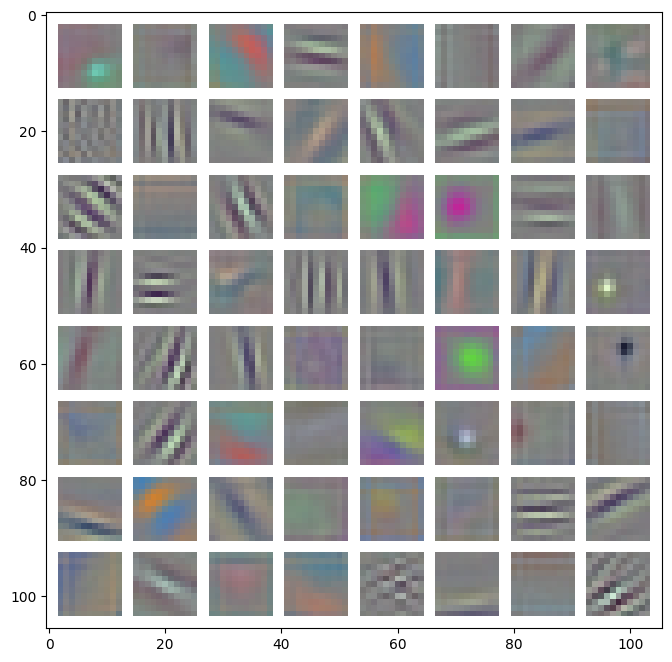

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(
    np.transpose(img_grid, (1, 2, 0))
)  # change channel order for compability with numpy & matplotlib
plt.show()

Видно, что модель научилась улавливать простые геометрические формы: края под разными углами, точки того или иного цвета. Фильтры AlexNet'а оказались настолько большими, что частично захватили не только простую локальную информацию, но и сложные градиенты или решётки.


## Визуализация фильтров промежуточных слоев

К сожалению, выполнить ту же операцию для фильтров на скрытых слоях едва ли представляется разумным: в отличие от трёхканальных фильтров первого слоя, веса которых легко визуализировать, фильтры поздних слоёв имеют гораздо больше каналов, что затрудняет их визуализацию. Пожалуй, единственным вариантом  является поканальное отображение весов, которое довольно сложно трактовать. Убедимся в этом, на примере ниже.

**Higher Layer: Visualize Filter**

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L06/weight_visualization.png" width="700"></center>

<center><em> We can visualize filters at higher layers, but not that interesting</em></center>

<center><em>Source: <a href="https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html">ConvNetJS CIFAR-10 example</a></em></center>

Визуализируем веса $2$-го сверточного слоя AlexNet.
Слой доступен через `features[3] `

In [ ]:
weights_of_conv2_layer = alexnet.features[3].weight.data  # extract weights
print(weights_of_conv2_layer.shape)

torch.Size([192, 64, 5, 5])


В нем $192$ фильтра, в каждом $64$ ядра. Поэтому ограничимся первым фильтром и выведем все его ядра.

In [ ]:
first_filter_kernels = weights_of_conv2_layer[0]
print(first_filter_kernels.shape)

torch.Size([64, 5, 5])


Чтобы использовать `image_grid`, входной тензор должен иметь формат $(B \times C \times H \times W)$. Поэтому добавим размерность, соответствующую каналам:

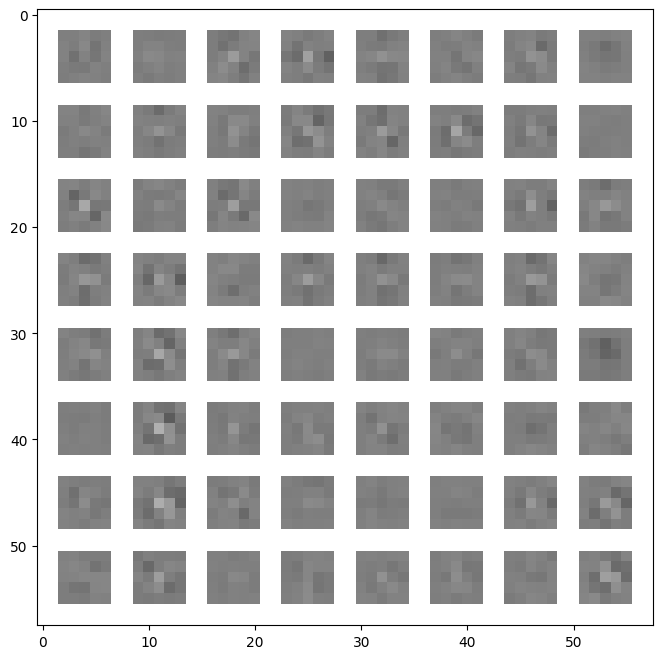

In [ ]:
img_grid = utils.make_grid(
    weights_of_conv2_layer[0].unsqueeze(1), pad_value=1  # add fake channel dim
)

plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(
    np.transpose((img_grid + 1) / 2, (1, 2, 0))
)  # change channel order for compability with numpy
plt.show()

Интерпретация такой визуализации довольно затруднительна, зато мы разобрались, как получать доступ к весам.

# Визуализация карт признаков

Наиболее очевидный метод визуализации заключается в том, чтобы показать активации сети во время прямого прохода. Для сетей ReLU активации обычно начинают выглядеть относительно сгущенными и плотными, но по мере развития обучения активации обычно становятся более редкими и локализованными.

На последних слоях свёрточной нейронной сети размеры рецептивных полей нейронов становятся сравнимы с размером исходного изображения, поэтому при визуализации их карт признаков становится понятно, какие нейроны реагируют на какие части изображений.

К примеру, на изображении ниже активация выделенного нейрона достигнута благодаря пикселям, примерно соответствующим расположению лица человека, поэтому можно предположить, что он научился находить лица на изображении. Более подробно об этом можно почитать в статье [Understanding Neural Networks Through Deep Visualization 🎓[arxiv]](https://arxiv.org/abs/1506.06579).

**Visualizing Activations**

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L06/visualization_activations.png" width="500"></center>

<center><em> conv5 feature map is $128\times13\times13$; visualize as $128$ $13\times13$ grayscale images</em></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf">Visualizing and Understanding</a></em></center>

В отличие от весов, карты признаков не сохраняются в памяти. Для того, чтобы получить к ним доступ, в PyTorch предусмотрен механизм под названием [Hooks 🛠️[doc]](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks).

Благодаря ему можно получить доступ к выходам или входам слоя как при прямом, так и при обратном распространении сигнала через сеть.



Зарегистрируем свой hook. Он просто выведет в консоль размеры карты признаков (выхода слоя).



In [ ]:
from torch import nn

# https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html


def module_hook(module: nn.Module, input, output):  # For nn.Module objects only.
    print("Hi, i am hook_1 ! ", input[0].shape)  # feature_map of previous layer


handle = alexnet.features[10].register_forward_hook(
    module_hook
)  # attach hook to last conv layer

Проверим, что он работает:

In [ ]:
import torch

out = alexnet(torch.randn(1, 3, 224, 224))

Hi, i am hook_1 !  torch.Size([1, 256, 13, 13])


Чтобы удалить hook, используйте метод `remove` дескриптора, который возвращает метод `register_forward_hook`:

In [ ]:
handle.remove()
out = alexnet(torch.randn(1, 3, 224, 224))

Вывода нет, hook отключился!

Теперь напишем hook, который выведет нам карту признаков.
Так как на выходе данного слоя $256$ каналов, выведем каждый отдельно, подав на вход `make_grid` тензор с $256$ элементами.

Для этого потребуется:
* удалить batch-измерение;
* добавить измерение, имитирующее канал для картинок.




In [ ]:
def module_hook(module: nn.Module, input, output):
    # activation_map = output.squeeze(0).unsqueeze(1) # alternative solution
    activation_map = input[0].permute(1, 0, 2, 3)  # B <--> C
    img_grid = (
        utils.make_grid(activation_map, pad_value=1, nrow=16, normalize=True) * 255
    )
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.imshow(
        img_grid.permute(1, 2, 0)
        .numpy()
        .astype("uint8")  # change channel order for compability with numpy
    )
    plt.show()


handle = alexnet.features[12].register_forward_hook(module_hook)

Чтобы карта признаков  была интерпретируема, надо использовать реальное изображение. Загрузим его:

In [1]:
!wget -q https://ml.gan4x4.ru/msu/dev-2.1/L06/fox.jpg

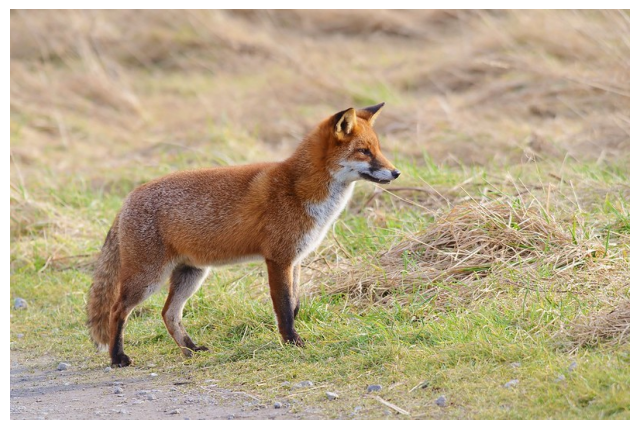

In [ ]:
from PIL import Image

img_fox = Image.open("fox.jpg")

plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(img_fox)
plt.axis("off")
plt.show()

Преобразуем изображение в тензор и подадим на вход модели:

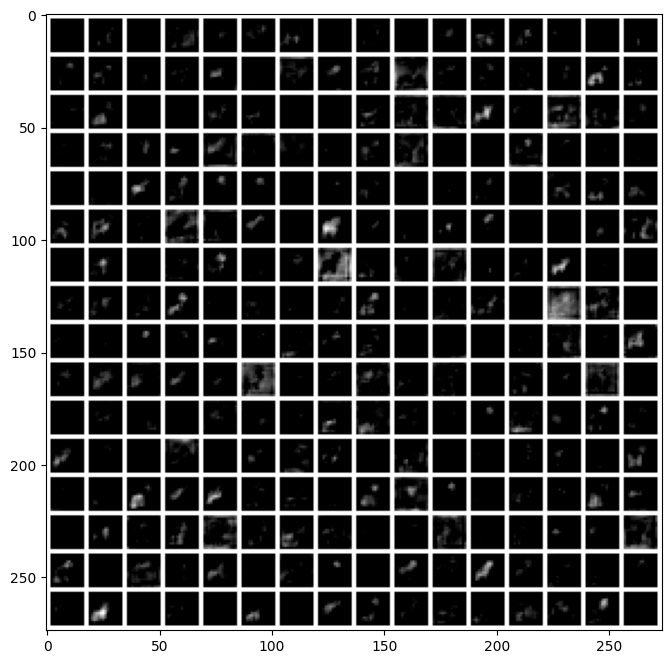

In [ ]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

tensor = transform(img_fox)
out = alexnet(tensor.unsqueeze(0))

Тут уже можно увидеть некоторые паттерны. Видно, что многие фильтры реагируют на лисицу.

Единственная опасная ловушка, которую можно легко заметить с помощью этой визуализации, заключается в том, что некоторые карты признаков могут быть равны нулю для многих различных входов. Это может указывать на мертвые фильтры и может быть симптомом слишком высокой скорости обучения.

Отключим наш hook, чтобы он не мешал дальнейшим экспериментам

In [ ]:
handle.remove()

Существуют техники, которые позволяют визуализировать паттерн, на который лучше всего активируется конкретный нейрон. Они основаны на подсчете градиента не по весам, а по входу (изображению) и его постепенной модификации.

Примеры:

* [[demo] 🎮 Exploring Neural Networks with Activation Atlases](https://distill.pub/2019/activation-atlas/)

* [[blog] ✏️ Feature Visualization](https://distill.pub/2017/feature-visualization/)
